## `trfermikit` versus `manta`
For each tool, I asked: 
* how many of the pacbio calls did the tool recover (TP) 
* how many calls did the tool make that didn't overlap a pacbio call (FP) 
* how many pacbio calls were missed by the tool (FN)

In [1]:
sample = "HG00514"
svtype = "DEL"
output = "../data/{}.{}".format(sample, svtype)

In [2]:
import json
import pandas as pd 

def add_performance(table, truvari_data, tool, calls):
    table.append([
            tool,
            calls,
            truvari_data['TP-base'],
            truvari_data['FN'],
            truvari_data['FP'], 
            truvari_data['TP-base'] + truvari_data['FN']
    ])
    
def create_performance_table():
    table = []
    with open('{}/truvari-pacbio-manta/summary.txt'.format(output)) as json_file:
        add_performance(table, json.load(json_file), 'manta', 'all')    
    with open('{}/truvari-pacbio-trfermikit/summary.txt'.format(output)) as json_file:
        add_performance(table, json.load(json_file), 'trfermikit', 'all')
    with open('{}/truvari-pacbio-trfermikit.unitigSupport/summary.txt'.format(output)) as json_file:
        add_performance(table, json.load(json_file), 'trfermikit', 'unitigSupport')
    with open('{}/truvari-pacbio-trfermikit.unitigSupport.thinned/summary.txt'.format(output)) as json_file:
        add_performance(table, json.load(json_file), 'trfermikit', 'unitigSupport.thinned')
    return table 

def extract_value(df, calls, truvari_class):
    return df[df['calls'] == calls][truvari_class].values[0]

def total_TP_count(df, calls_1, calls_2):
    return extract_value(df, calls_1, 'TP') + extract_value(df, calls_2, 'TP')

def total_FP_count(df, calls_1, calls_2):
    return extract_value(df, calls_1, 'FP') + extract_value(df, calls_2, 'FP')

def sum_counts(df, columns, calls_1, calls_2): 
    return pd.DataFrame([[
        'trfermikit', 
        '{} + {}'.format(calls_1, calls_2), 
        total_TP_count(df, calls_1, calls_2), 
        '.', 
        total_FP_count(df, calls_1, calls_2), 
        '.'
    ]], columns=columns)
    
def visualize_performance_table():
    from IPython.display import HTML
    columns = ['tool', 'calls', 'TP', 'FN', 'FP', '# real events']
    df_ = pd.DataFrame(
        create_performance_table(), 
        columns=columns
    )
    return HTML(df_.to_html(index=False))
    
visualize_performance_table()

tool,calls,TP,FN,FP,# real events
manta,all,0,0,0,0
trfermikit,all,0,0,2,0
trfermikit,unitigSupport,0,0,1,0
trfermikit,unitigSupport.thinned,0,0,0,0


The table above reports poor performance of `manta` in tandem-repeat regions. This has been found by others; see panels B and C at https://www.nature.com/articles/s41467-019-11146-4/figures/2 

After filtering `trfermikit` calls (see table), `trfermikit` performs comparably to `manta`.

[Technical Note: applying the cluster-thinning filter eliminates TPs primarily because there are clusters harboring more than one event, e.g., the pacbio contig is “fragmented”. ]

## `trfermikit` picks up a significant number of calls missed by `manta` 

`trfermikit` picks up the majority of `manta` TPs while also discovering a significant number of pacbio events that `manta` missed:  

/uufs/chpc.utah.edu/common/HIPAA/u6018199/.conda/envs/chaisson_2019/lib/python3.7/site-packages/matplotlib_venn/_venn2.py:50: UserWarning: Both circles have zero area
  warnings.warn("Both circles have zero area")


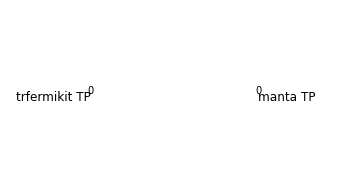

In [3]:
def list_to_value(list_): 
    value, = list_
    return int(value)

overlap_fraction = 0.9

def tr_fermikit_TP_intersect_manta(manta_callset): 
    list_ = ! bedtools intersect -u -wb -f $overlap_fraction -r \
      -a $output/truvari-pacbio-manta/$manta_callset".vcf" \
      -b $output/truvari-pacbio-trfermikit.unitigSupport.thinned/tp-base.vcf \
      | wc -l 
    return list_to_value(list_)

def tr_fermikit_TP_less_manta(manta_callset):
    list_ = ! bedtools subtract -A -f $overlap_fraction -r \
      -a $output/truvari-pacbio-trfermikit.unitigSupport.thinned/tp-base.vcf \
      -b $output/truvari-pacbio-manta/$manta_callset".vcf" \
      | wc -l
    return list_to_value(list_)

def manta_less_tr_fermikit_TP(manta_callset):
    list_ = ! bedtools subtract -A -f $overlap_fraction -r \
      -a $output/truvari-pacbio-manta/$manta_callset".vcf" \
      -b $output/truvari-pacbio-trfermikit.unitigSupport.thinned/tp-base.vcf \
    | wc -l 
    return list_to_value(list_)

def check(manta_callset): 
    if manta_callset != 'fn' and manta_callset != 'tp-base': 
        raise Exception
    else: 
        pass
        
# https://towardsdatascience.com/how-to-create-and-beautify-venn-diagrams-in-python-331129bd4ed3
from matplotlib_venn import venn2

def tr_fermikit_manta_venn2(manta_callset, manta_label):
    check(manta_callset)
    vd = venn2(
        subsets = {
            '10': tr_fermikit_TP_less_manta(manta_callset),
            '11': tr_fermikit_TP_intersect_manta(manta_callset),
            '01': manta_less_tr_fermikit_TP(manta_callset)
        }, 
        set_labels = ('trfermikit TP', manta_label))
    return vd

_ = tr_fermikit_manta_venn2(manta_callset='tp-base', manta_label='manta TP')

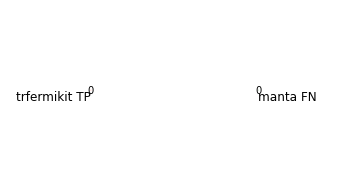

In [4]:
_ = tr_fermikit_manta_venn2(manta_callset='fn', manta_label='manta FN')